# Project 3

Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set.

How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Source: Natural Language Processing with Python, exercise 6.10.2.

[Explanation](https://www.youtube.com)

## Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
import nltk
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB

## Load Names Corpus Dataset 

In [2]:
files = nltk.corpus.names.fileids()
files

['female.txt', 'male.txt']

## Merge both text files into one DataFrame

In [3]:
names_df = pd.DataFrame(columns=['name', 'gender'])

for file in files:
    name, extension = file.split('.')
    temp_df = pd.DataFrame({'name':nltk.corpus.names.words(file), 'gender':name})
    names_df = pd.concat([names_df, temp_df])

In [4]:
names_df

,name,gender
0,Abagael,female
1,Abagail,female
2,Abbe,female
3,Abbey,female
4,Abbi,female
...,...,...
2938,Zeus,male
2939,Zippy,male
2940,Zollie,male
2941,Zolly,male


## Create Training, Dev-Test and Testing Set

In [5]:
df_shuffled = shuffle(names_df, random_state=123)

train_set = df_shuffled.iloc[:len(names_df)-1000]  
dev_test_set = df_shuffled.iloc[500:1000]
test_set = df_shuffled.tail(500)

print("Train Set: ", len(train_set))
print("Dev-Test Set: ", len(dev_test_set))
print("Test Set: ", len(test_set))

Train Set:  6944
Dev-Test Set:  500
Test Set:  500


## Exploratory Data Analysis

### Total Names by Gender

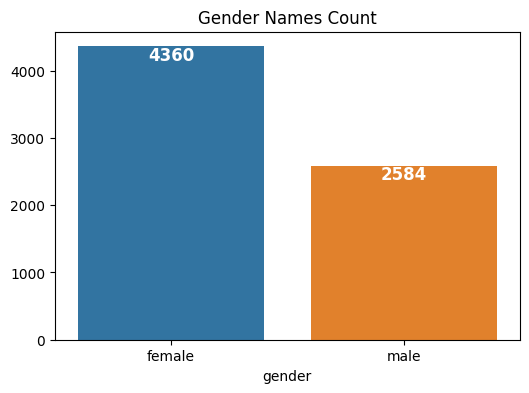

In [6]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=train_set, x='gender', hue='gender')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height() - 0.1),  # Slightly below the top
                ha='center', va='top', fontsize=12, color='white', fontweight='bold')


plt.title('Gender Names Count')
plt.ylabel('')
plt.show()

## Create Gender Features

- First Letter
- Last Letter
- First Two Letters
- Last Two Lettes
- Vowel Count
- Bigrams
- Syllables

In [7]:
def count_vowels(name):
    return sum(1 for char in name.lower() if char in 'aeiou')

def create_features(df):
    SSP = SyllableTokenizer()
    
    df.loc[:, 'name'] = df['name'].str.lower()
    
    df.loc[:, 'first_letter'] = df['name'].str[0]
    df.loc[:, 'last_letter'] = df['name'].str[-1]
    df.loc[:, 'first_two_letters'] = df['name'].str[:2]
    df.loc[:, 'last_two_letters'] = df['name'].str[-2:]
    df.loc[:, 'name_length'] = df['name'].str.len()
    df.loc[:, 'vowel_count'] = df['name'].apply(count_vowels)
    df.loc[:, 'bigram'] = df['name'].apply(lambda x: list(ngrams(x, 2)))
    df.loc[:, 'syllable'] = df['name'].apply(lambda x: len(SSP.tokenize(x)))

    return df

In [8]:
features_train_set = train_set.copy()
features_dev_test_set = dev_test_set.copy()
features_test_set = test_set.copy()

features_train_set = create_features(features_train_set)
features_dev_test_set = create_features(features_dev_test_set)
features_test_set = create_features(features_test_set)

/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/nltk/tokenize/sonority_sequencing.py:102: UserWarning: Character not defined in sonority_hierarchy, assigning as vowel: ' '
  warnings.warn(


In [9]:
features_train_set

,name,gender,first_letter,last_letter,first_two_letters,last_two_letters,name_length,vowel_count,bigram,syllable
803,carrie,female,c,e,ca,ie,6,3,"[(c, a), (a, r), (r, r), (r, i), (i, e)]",2
2939,leisha,female,l,a,le,ha,6,3,"[(l, e), (e, i), (i, s), (s, h), (h, a)]",2
4061,rayna,female,r,a,ra,na,5,2,"[(r, a), (a, y), (y, n), (n, a)]",2
3241,malinde,female,m,e,ma,de,7,3,"[(m, a), (a, l), (l, i), (i, n), (n, d), (d, e)]",3
4729,toni,female,t,i,to,ni,4,2,"[(t, o), (o, n), (n, i)]",2
...,...,...,...,...,...,...,...,...,...,...
54,albrecht,male,a,t,al,ht,8,2,"[(a, l), (l, b), (b, r), (r, e), (e, c), (c, h...",2
1243,inglebert,male,i,t,in,rt,9,3,"[(i, n), (n, g), (g, l), (l, e), (e, b), (b, e...",3
1977,gipsy,female,g,y,gi,sy,5,1,"[(g, i), (i, p), (p, s), (s, y)]",2
1806,neale,male,n,e,ne,le,5,3,"[(n, e), (e, a), (a, l), (l, e)]",2


### Relative Frequency of First Letter by Gender

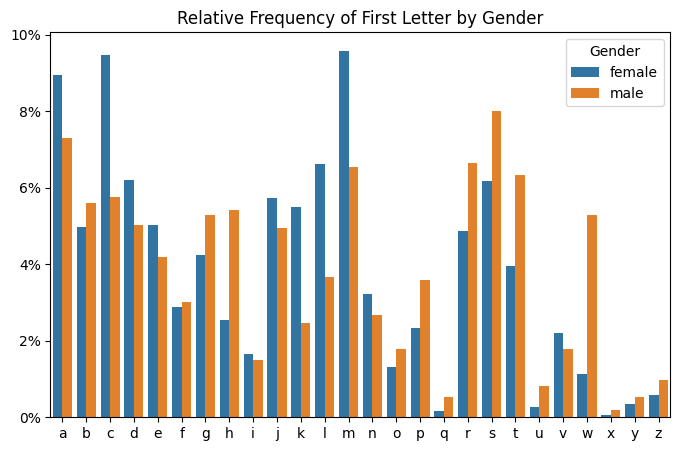

In [10]:
gender_counts = features_train_set.groupby(['gender', 'first_letter']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='first_letter', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of First Letter by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Last Letter by Gender

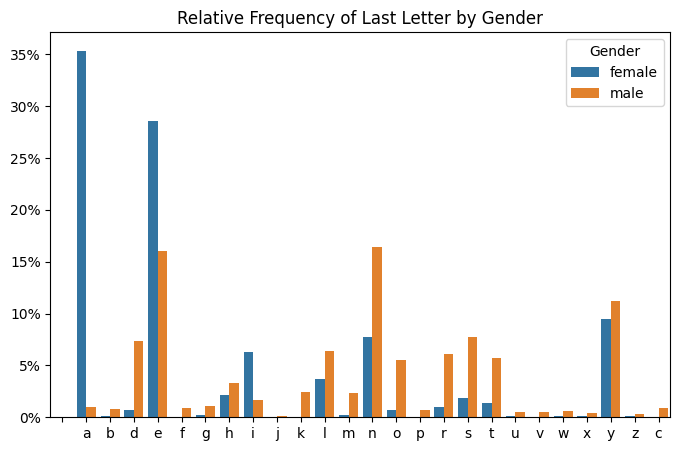

In [11]:
gender_counts = features_train_set.groupby(['gender', 'last_letter']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='last_letter', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Last Letter by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Name Length by Gender

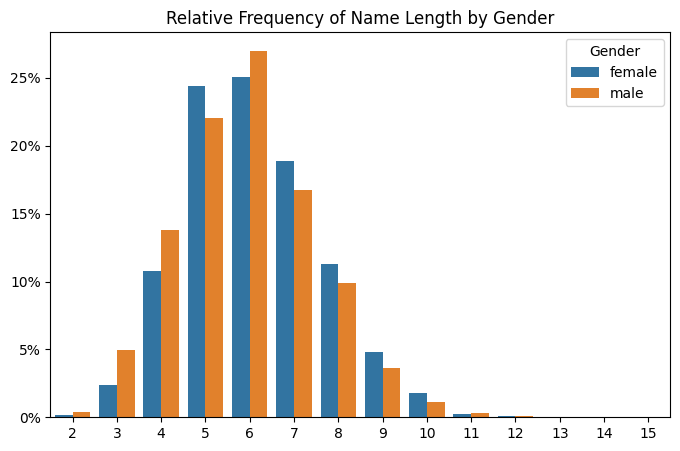

In [12]:
gender_counts = features_train_set.groupby(['gender', 'name_length']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='name_length', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Name Length by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Vowel Count by Gender

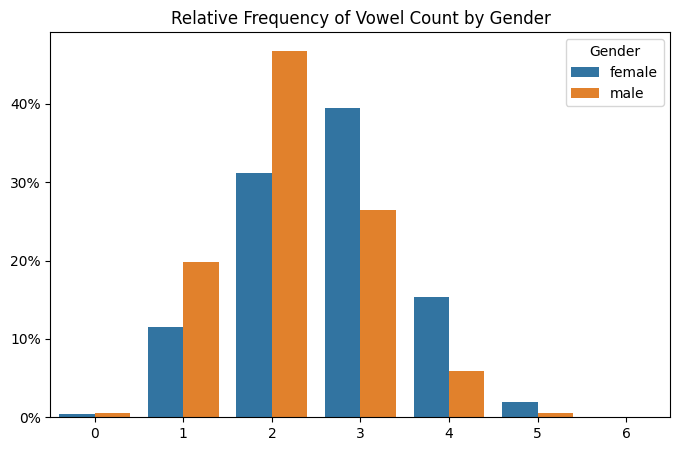

In [13]:
gender_counts = features_train_set.groupby(['gender', 'vowel_count']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='vowel_count', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Vowel Count by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

### Relative Frequency of Bigram Count by Gender

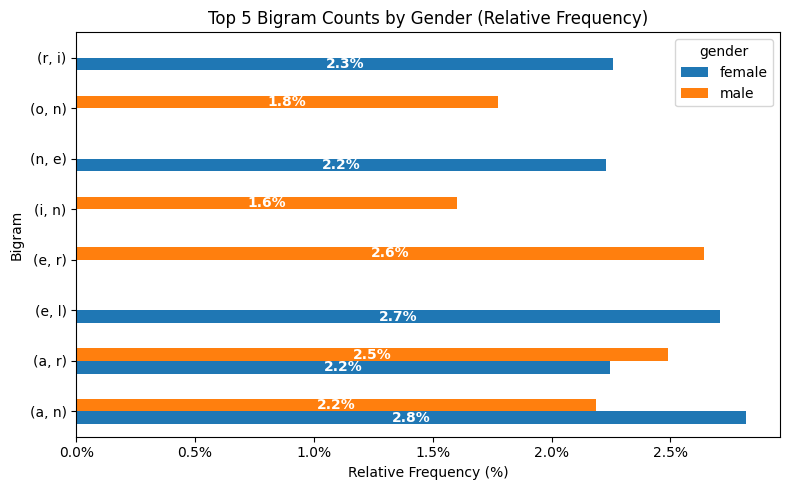

In [14]:
bigram_expanded = features_train_set.explode('bigram')[['gender', 'bigram']]
bigram_expanded = bigram_expanded.reset_index(drop=True)

bigram_counts = bigram_expanded.groupby(['gender', 'bigram']).size().reset_index(name='count')

gender_totals = bigram_counts.groupby('gender')['count'].transform('sum')
bigram_counts['relative_frequency'] = (bigram_counts['count'] / gender_totals) * 100

bigram_counts_sorted = bigram_counts.sort_values(by='count', ascending=False)
top_10_bigrams_gender = bigram_counts_sorted.groupby('gender').head(5).reset_index(drop=True)

bigram_pivot = top_10_bigrams_gender.pivot_table(index='bigram', columns='gender', values='relative_frequency', fill_value=0)

plt.figure(figsize=(8, 5))
ax = bigram_pivot.plot(kind='barh', stacked=False, ax=plt.gca()) 

plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.1f}%'))  

for p in ax.patches:
    width = p.get_width()  
    if width > 0: 
        ax.text(width/2, p.get_y() + p.get_height() / 2, f'{width:.1f}%', 
                va='center', 
                ha='center', 
                fontsize=10,
                fontweight='bold',
                color='white')

plt.title('Top 5 Bigram Counts by Gender (Relative Frequency)')
plt.ylabel('Bigram')
plt.xlabel('Relative Frequency (%)')

plt.tight_layout()
plt.show()

### Relative Frequency of Syllable Count by Gender

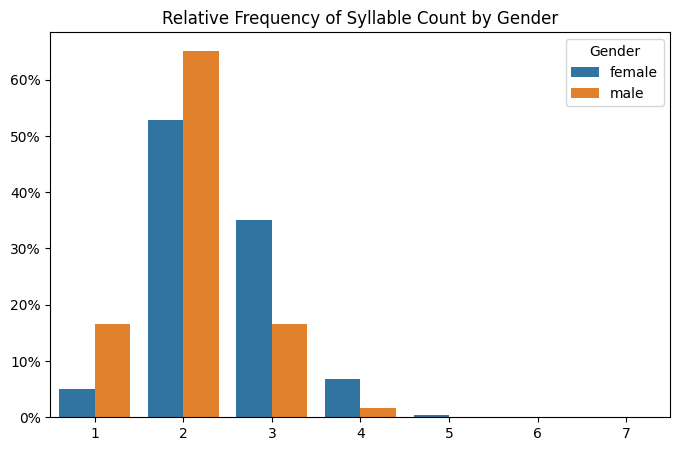

In [15]:
gender_counts = features_train_set.groupby(['gender', 'syllable']).size().reset_index(name='count')
gender_totals = gender_counts.groupby('gender')['count'].transform('sum')
gender_counts['relative_frequency'] = gender_counts['count'] / gender_totals * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='syllable', y='relative_frequency', hue='gender', data=gender_counts)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))

plt.title('Relative Frequency of Syllable Count by Gender')
plt.xlabel('')
plt.ylabel('')
plt.legend(title='Gender')
plt.show()

## Model Development

### Encoding

In [16]:
prep_features_train_set = features_train_set.drop(columns=['name'])
prep_features_dev_test_set = features_dev_test_set.drop(columns=['name'])

def extract_bigram_features(df):
    df['bigram_count'] = df['bigram'].apply(lambda x: len(x))
    return df

prep_features_train_set = extract_bigram_features(prep_features_train_set)
prep_features_dev_test_set = extract_bigram_features(prep_features_dev_test_set)

def encode_text_columns(df, columns):
    encoder = LabelEncoder()
    for col in columns:
        df[col] = encoder.fit_transform(df[col])
    return df

prep_features_train_set = encode_text_columns(prep_features_train_set, 
                                              ['first_letter', 'last_letter', 'first_two_letters', 'last_two_letters'])
prep_features_dev_test_set = encode_text_columns(prep_features_dev_test_set, 
                                                 ['first_letter', 'last_letter', 'first_two_letters', 'last_two_letters'])

gender_encoder = LabelEncoder()
prep_features_train_set['gender'] = gender_encoder.fit_transform(prep_features_train_set['gender'])
prep_features_dev_test_set['gender'] = gender_encoder.transform(prep_features_dev_test_set['gender'])

prep_features_train_set['syllable_count'] = prep_features_train_set['syllable']
prep_features_dev_test_set['syllable_count'] = prep_features_dev_test_set['syllable']

prep_features_train_set = prep_features_train_set.drop(columns=['bigram', 'syllable'])
prep_features_dev_test_set = prep_features_dev_test_set.drop(columns=['bigram', 'syllable'])

### Decision Tree

In [17]:
X_train = prep_features_train_set.drop(columns=['gender'])
y_train = prep_features_train_set['gender']

X_test = prep_features_dev_test_set.drop(columns=['gender'])
y_test = prep_features_dev_test_set['gender']

clf = DecisionTreeClassifier(random_state=42, max_depth=4)
clf.fit(X_train, y_train)

y_pred_dt = clf.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")

Decision Tree Accuracy: 0.59


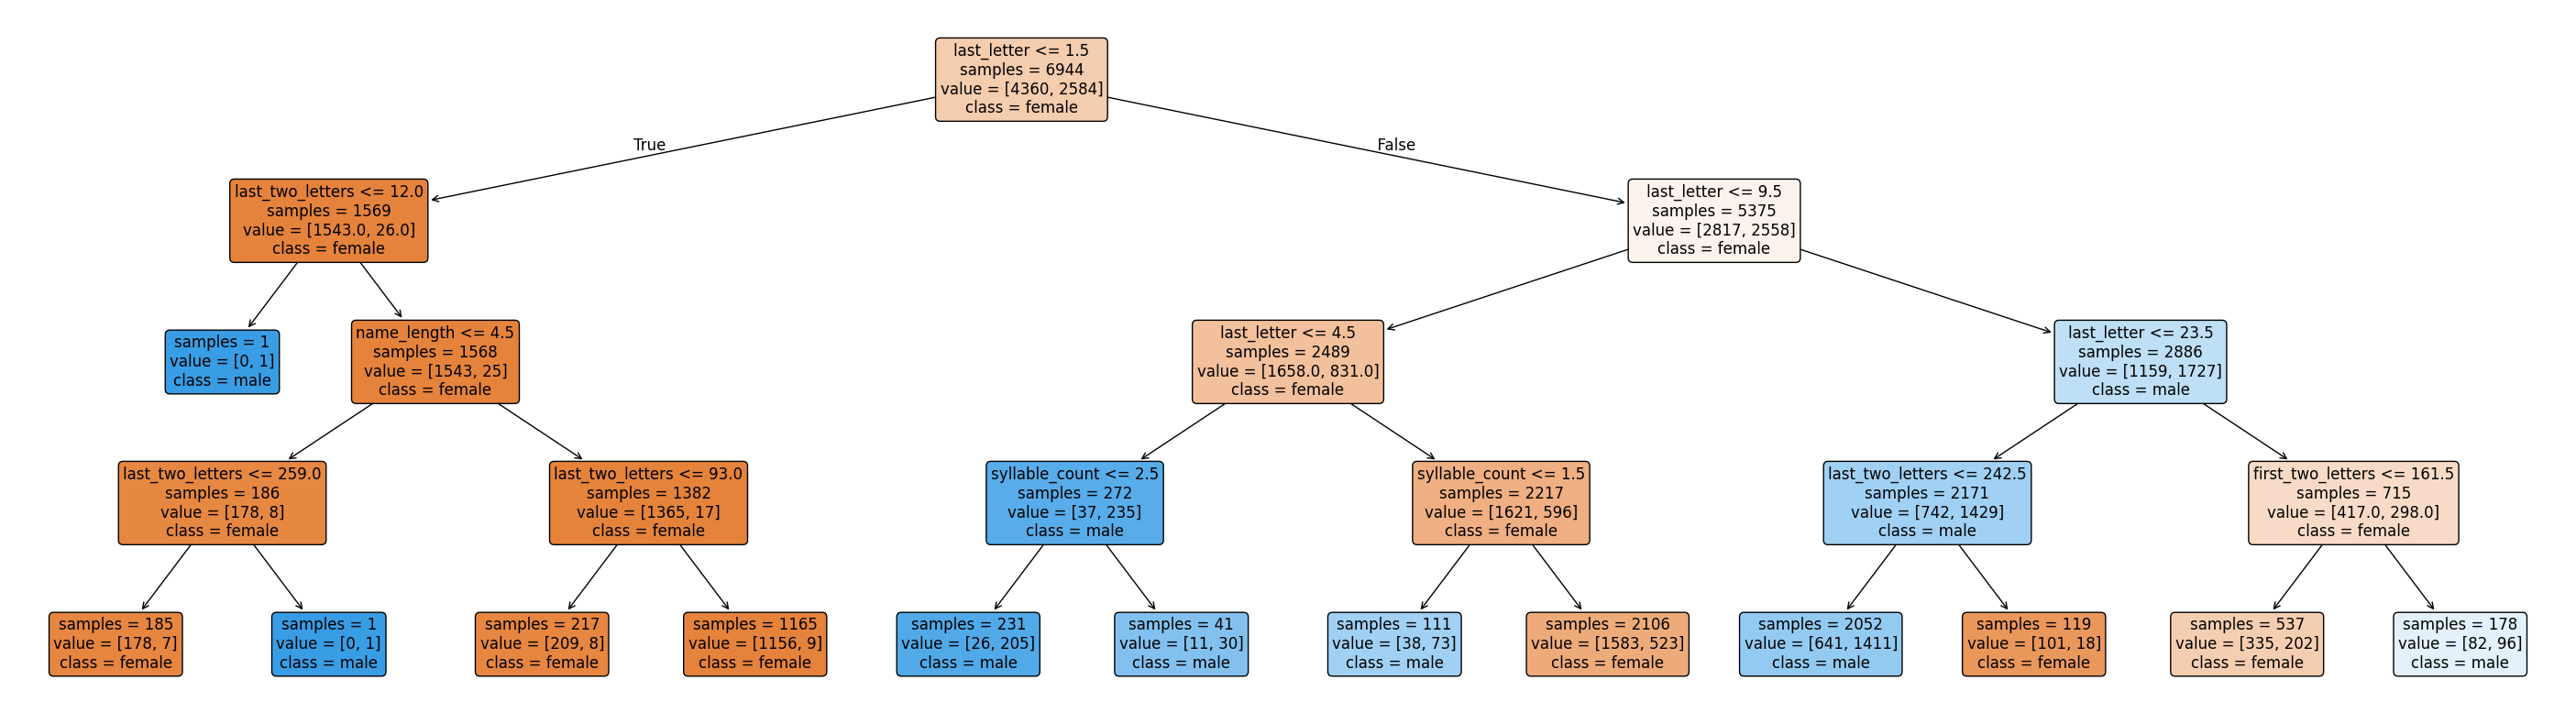

In [18]:
plt.figure(figsize=(36, 10))
plot_tree(clf, 
          filled=True, 
          feature_names=X_train.columns, 
          class_names=gender_encoder.classes_, 
          rounded=True, 
          fontsize=12, 
          impurity=False,  
          label='all')
plt.show()

### Naive Bayes Classifiers

In [19]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

y_pred_nb = nb_classifier.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")

Naive Bayes Accuracy: 0.54


/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/johncruz/Documents/GitHub/Social-Network-Analysis/chapter2/.venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of the Random Forest model: {accuracy_rf:.2f}")

Accuracy of the Random Forest model: 0.65


In [21]:
from sklearn.metrics import accuracy_score, classification_report

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print(f"Accuracy of Decision Tree model: {accuracy_dt:.2f}")
print(f"Accuracy of Naive Bayes model: {accuracy_nb:.2f}")
print(f"Accuracy of Random Forest model: {accuracy_rf:.2f}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.44      0.58       321
           1       0.46      0.87      0.60       179

    accuracy                           0.59       500
   macro avg       0.66      0.65      0.59       500
weighted avg       0.71      0.59      0.59       500

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.43      0.54       321
           1       0.42      0.75      0.54       179

    accuracy                           0.54       500
   macro avg       0.59      0.59      0.54       500
weighted avg       0.63      0.54      0.54       500

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.59      0.68       321
           1       0.51      0.75      0.61       179

    accuracy                           0.65       500
   macro avg       

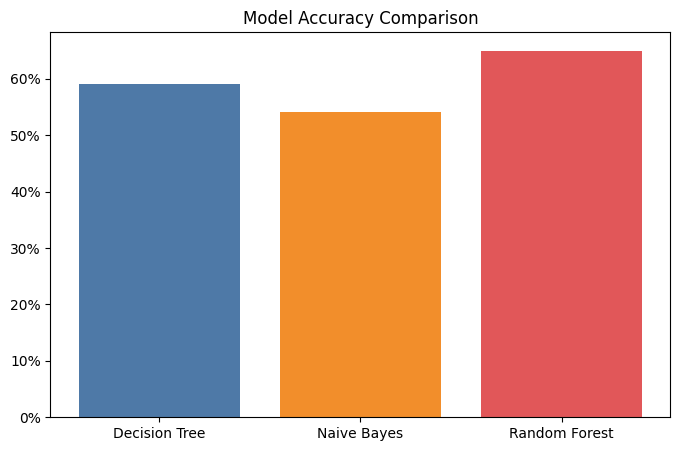

In [22]:
models = ['Decision Tree', 'Naive Bayes', 'Random Forest']
accuracies = [accuracy_dt, accuracy_nb, accuracy_rf]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['#4E79A7', '#F28E2B', '#E15759'])
plt.xlabel('')
plt.ylabel('')
plt.title('Model Accuracy Comparison')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.show()